## Sometimes the frame count does not match the number of sync pulses
<br>We observe two errors: too many frames OR too few frames.
<br>
<br>If there are too many frames, we can compare the native timestamps (from the .h5 file) to the sync timestamps to find where in the recording the mismatch happens (it is usually in the middle of the recording). Then we can correct the mismatch by removing the extra frames then aligning with the sync clock. Use the below code to do so.
<br>
<br>If there are missing frames, the number of native timestamps is actually equal to the number of sync timestamps. So the video itself is missing frames even though it has timestamps for them. I don't yet know how to correctly align in this case. For now we can delete the first few sync timestamps to match the lengths. So far in our recordings, this type of mismatch only occurs for a small number of frames (< 16 so far).

In [1]:
import h5py
import os
import sys

import cv2
import gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from allensdk.brain_observatory.sync_dataset import Dataset

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie, get_sync_frame_times

In [4]:
%matplotlib notebook

Get Templeton log for experiment list

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

# Look for experiments that have frame/sync mismatch

In [6]:
psydir = r'P:\\' # this is the directory that contains all of the mouse folders

### Testing with one subject

iloc[21]: 669117 (pilot_ur) has 114 extra frames
<br>iloc[25]: 676726 (aw_psi) frames = sync (NO weird clock shifts)
<br>iloc[34]: 698242 (aw_psi) has 26 extra frames (clock shift in middle of recording)

In [7]:
testrow = metadata.iloc[34]
print(testrow.mouse_name)

recdir = os.path.join(psydir, testrow.mouse_name, testrow.exp_name, r'experiment1\recording1')
print(recdir)

exp = EEGexp(recdir, preprocess=False, make_stim_csv=False)
sync_data = exp._load_sync_dataset()

mouse689242
P:\\mouse689242\aw_psi_2023-07-19_10-29-49\experiment1\recording1
Experiment type: electrical and sensory stimulation


In [8]:
pupilmovie = Movie(filepath=exp.pupilmovie_file, sync_filepath=exp.sync_file, sync_channel='eyetracking')
print('Pupil frame count = {:d}'.format(pupilmovie.frame_count))
print('Pupil sync timestamps = {:d}'.format(len(pupilmovie.sync_timestamps)))

Pupil frame count = 233069
Pupil sync timestamps = 233043


C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:41: UserWarning: NONMATCHING timestamp counts
There are 233043 timestamps in sync and 233069 timestamps in the associated camera file
these should match
  len(self.sync_timestamps), len(self.timestamps_from_file)))


In [9]:
pupilvid = cv2.VideoCapture(exp.pupilmovie_file)
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
pupilsync = sync_data.get_edges(keys=('eyetracking',), kind='rising', units='seconds')
print('Pupil sync count = {:d}'.format(len(pupilsync)))
print('Extra frames = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(pupilsync)))

Pupil frame count = 233069
Pupil sync count = 233043
Extra frames = 26


In [10]:
bodyvid = cv2.VideoCapture(exp.bodymovie_file)
print('Body frame count = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT))))
bodysync = sync_data.get_edges(keys=('behavior',), kind='rising', units='seconds')
print('Body sync count = {:d}'.format(len(bodysync)))
print('Extra frames = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(bodysync)))

Body frame count = 462784
Body sync count = 462742
Extra frames = 42


### Investigate sync time intervals and frame time intervals

In [11]:
## Load native frame times ##
pupilh5 = h5py.File(exp.pupilmovie_file.replace('.avi','.h5'), 'r')
pupil_ts = np.hstack((0, np.cumsum(pupilh5['frame_intervals'])))

## Load falling edges, intervals between falling edges match frame intervals better ##
pfalling = sync_data.get_edges(keys=('eyetracking',), kind='falling', units='seconds')

In [12]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil timestamp count = {:d}'.format(len(pupil_ts)))
print('Pupil sync falling edges = {:d}'.format(len(pfalling)))

Pupil frame count = 233069
Pupil timestamp count = 233069
Pupil sync falling edges = 233043


### Some intervals are longer than expected. Do they align?

In [15]:
tt = 0.085
print(np.nonzero(np.diff(pupil_ts) > tt)[0])
print(np.nonzero(np.diff(pfalling) > tt)[0])

[     9    349    489   2649   5139   6789   7759   7779   8009   9649
  10689  12879  12899  13199  13209  13629  13969  18549  19189  19879
  20249  20279  21289  21659  21939  22549  22829  23559  24209  24819
  25519  26159  26449  26619  27149  27419  29709  30609  31969  32929
  33599  34069  34089  35079  36069  37089  49369  51499  55359  56459
  59659  60279  62979  62989  63289  65959  67159  69599  72369  72539
  75399  75409  75419  80509  81859  82799  83729  83759  87229  87509
  87869  89119  89849  90699  91019  92579  92909  93549  94159  97099
  98029  99949 101589 102719 103409 104189 105459 106159 110569 111019
 111659 112359 116769 117399 117749 118669 121259 121579 128919 129279
 129679 130579 132419 134049 135049 135069 136859 137149 139769 139819
 140189 140839 141159 141469 142859 145909 146849 148819 151179 151819
 152479 155439 158679 158949 160299 160909 163159 163199 164099 164419
 164499 166989 169859 170479 170549 170619 170639 171999 172369 173309
 17366

698242 (aw_psi) = [163165, 163205]
<br> 669117 (pilot_ur) = [139239, 144605]
<br> 689329 (aw_psi) = [61009, 61280]

In [16]:
indwins = [163165, 163205]

<IPython.core.display.Javascript object>


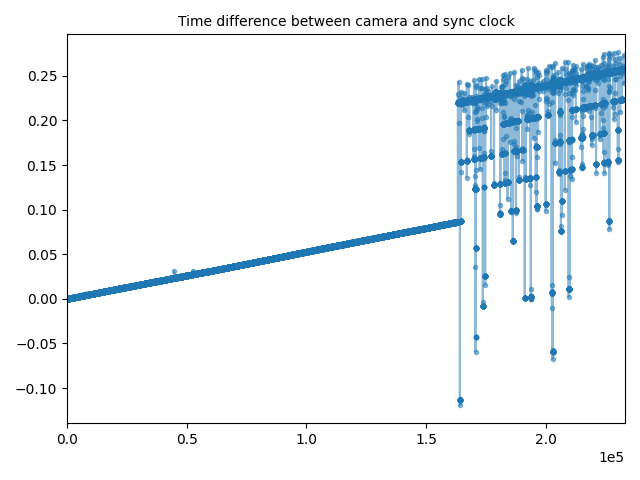

(0.0, 233043.0)

In [17]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
# ax.axvline(indwins[0], color='r', alpha=0.5)
# ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

### Remove extra frame times

In [18]:
len(pupil_ts)

233069

In [19]:
len(pupilsync)

233043

In [20]:
messind = 163199 # 698242-163199, 669117-143986, 689239-61152, 720762ket-138068

if len(pupil_ts) > len(pupilsync):
    num_frames = len(pupil_ts) - len(pupilsync)
    print('There are {:d} extra frames...deleting them.'.format(num_frames))
    new_ts = np.delete(pupil_ts, np.arange(messind, messind+num_frames))
elif len(pupil_ts) < len(pupilsync):
    num_syncs = len(pupilsync) - len(pupil_ts)
    print('There are {:d} extra sync pulses...deleting the extras from the end.'.format(num_syncs))
    new_sync = pupilsync[:len(pupil_ts)]

There are 26 extra frames...deleting them.


#### Test it

<IPython.core.display.Javascript object>


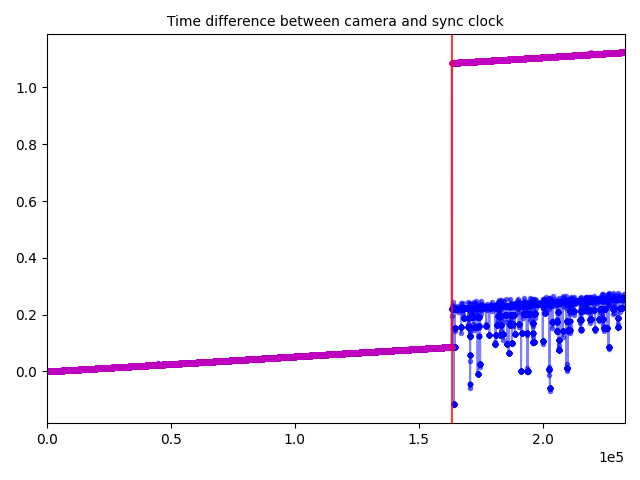

(0.0, 233043.0)

In [21]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
newtimediff = (new_ts - new_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(newtimediff, marker='.', color='m', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

## Looks good, now remove frames from pupil .csv

In [22]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil sync count = {:d}'.format(len(pupilsync)))

Pupil frame count = 233069
Pupil sync count = 233043


In [23]:
files = os.listdir(exp.data_folder)
pupil_file = exp.data_folder + '/' + next(file for file in files if file.split('_')[0] == 'Pupileye')
print(pupil_file)

P:\\mouse689242\aw_psi_2023-07-19_10-29-49\experiment1\recording1/Pupileye_aw_psi_2023-07-19_10-29-49.csv


In [24]:
pupil_data = pd.read_csv(pupil_file)
print(len(pupil_data))
pupil_data.head()

233069


,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
0,0.0,267.990975,245.380976,96.440014,92.144431,1.483733,96.440014,366.368129,NaN
1,1.0,262.040621,244.660911,97.517336,89.617221,1.759023,97.517336,365.861598,NaN
2,2.0,261.884165,244.825436,97.786780,89.509054,1.757601,97.786780,366.503100,NaN
3,3.0,262.106636,244.796289,97.706360,89.752395,1.734074,97.706360,366.033691,NaN
4,4.0,261.686549,244.789275,97.729061,89.768926,1.740599,97.729061,366.721751,NaN


In [25]:
corrected_pupil_data = pupil_data.drop(labels=np.arange(messind, messind+num_frames), axis=0)
print(len(corrected_pupil_data))

233043


In [26]:
corrected_pupil_data['sync_time'] = pupilsync
corrected_pupil_data.head()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
0,0.0,267.990975,245.380976,96.440014,92.144431,1.483733,96.440014,366.368129,26.79805
1,1.0,262.040621,244.660911,97.517336,89.617221,1.759023,97.517336,365.861598,26.81970
2,2.0,261.884165,244.825436,97.786780,89.509054,1.757601,97.786780,366.503100,26.83990
3,3.0,262.106636,244.796289,97.706360,89.752395,1.734074,97.706360,366.033691,26.87341
4,4.0,261.686549,244.789275,97.729061,89.768926,1.740599,97.729061,366.721751,26.90686


In [27]:
pupil_data.tail()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
233064,233064.0,290.953983,241.680049,118.589239,115.611884,3.048351,118.589239,373.458478,NaN
233065,233065.0,290.993332,241.555401,118.435286,115.694092,3.051231,118.435286,373.773609,NaN
233066,233066.0,290.861798,241.403127,118.625408,115.552237,3.015920,118.625408,372.787826,NaN
233067,233067.0,290.689362,241.178549,118.450360,115.444129,3.020072,118.450360,373.613491,NaN
233068,233068.0,290.430492,240.990047,118.648728,115.208302,2.991236,118.648728,373.460119,NaN


In [28]:
corrected_pupil_data.tail()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
233064,233064.0,290.953983,241.680049,118.589239,115.611884,3.048351,118.589239,373.458478,7822.11758
233065,233065.0,290.993332,241.555401,118.435286,115.694092,3.051231,118.435286,373.773609,7822.15140
233066,233066.0,290.861798,241.403127,118.625408,115.552237,3.015920,118.625408,372.787826,7822.18423
233067,233067.0,290.689362,241.178549,118.450360,115.444129,3.020072,118.450360,373.613491,7822.21749
233068,233068.0,290.430492,240.990047,118.648728,115.208302,2.991236,118.648728,373.460119,7822.25222


## Now save pupil .csv with aligned timestamps

In [29]:
corrected_pupil_data.to_csv(pupil_file, index=False)

## Test detrending the line

Doesn't quite work as well as I hoped

In [25]:
slope = np.mean(np.diff(timediff[:indwins[0]]))
detrend_timediff = timediff - slope*np.arange(len(timediff))

In [26]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(detrend_timediff, marker='.', color='c', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

<IPython.core.display.Javascript object>

(0.0, 174750.0)

In [27]:
avgdt = np.mean(detrend_timediff[:indwins[0]])
print(avgdt)
stddt = np.std(detrend_timediff[:indwins[0]])
print(stddt)

0.0002873595475388248
0.00016291322289725186


<IPython.core.display.Javascript object>


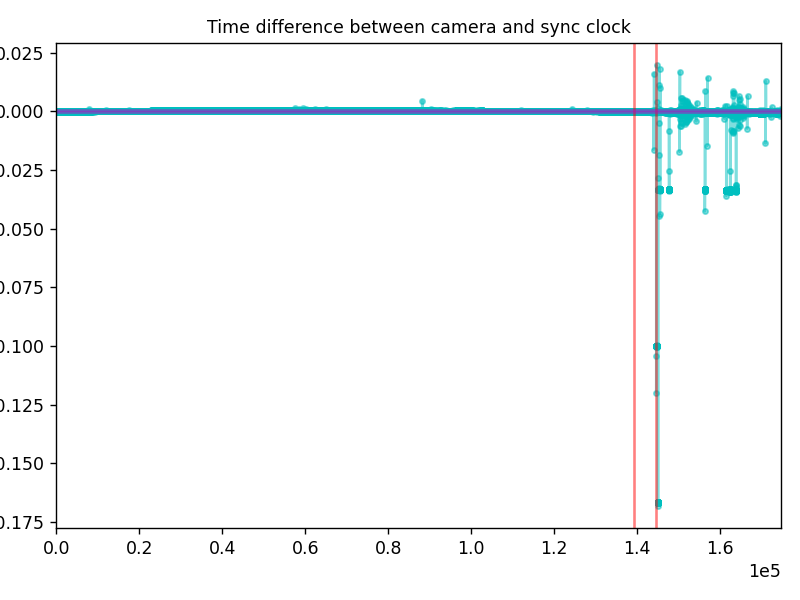

(0.0, 174750.0)

In [29]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
# ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(detrend_timediff, marker='.', color='c', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.axhline(avgdt + 2*stddt, color='m', alpha=0.5)
ax.axhline(avgdt - 2*stddt, color='m', alpha=0.5)
ax.set_xlim(0, len(pfalling))